# Colon Cancer Classification
We will be using a modified version of the “CRCHistoPhenotypes" dataset for this task. The dataset consists
of 27x27 RGB images of colon cells from 99 different patients and we are expected to use the dataset to
perform two tasks:
- Classify images according to whether given cell image represents a cancerous cell or not (`isCancerous`).
- Classify images according to cell-type, such as: fibroblast, inflammatory, epithelial or others.

## Cancerous Cell Classification
In this section, we will classify images into 2 categories: `cancer` and `not-cancer`.

In [1]:
import os
import glob
import shutil
from pathlib import Path

import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Dense, Dropout, MaxPooling2D, Flatten, ZeroPadding2D, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from matplotlib import pyplot as plt

%matplotlib inline

Load the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
!gdown https://drive.google.com/uc?id=1Ypdy3Tzl8TTudbbuJqWfmnhcblTXG-y1 -O data.zip
!unzip -qq data.zip

Downloading...
From: https://drive.google.com/uc?id=1Ypdy3Tzl8TTudbbuJqWfmnhcblTXG-y1
To: /content/drive/My Drive/Colab Notebooks/data.zip
40.7MB [00:00, 79.2MB/s]


In [4]:
!unzip Image_classification_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: patch_images/2445.png   
  inflating: patch_images/19898.png  
  inflating: patch_images/10102.png  
  inflating: patch_images/1164.png   
  inflating: patch_images/9538.png   
  inflating: patch_images/7515.png   
  inflating: patch_images/11234.png  
  inflating: patch_images/3773.png   
  inflating: patch_images/19668.png  
  inflating: patch_images/5302.png   
  inflating: patch_images/18576.png  
  inflating: patch_images/17645.png  
  inflating: patch_images/5464.png   
  inflating: patch_images/18210.png  
  inflating: patch_images/17123.png  
  inflating: patch_images/10894.png  
  inflating: patch_images/21491.png  
  inflating: patch_images/11552.png  
  inflating: patch_images/20957.png  
  inflating: patch_images/3015.png   
  inflating: patch_images/22198.png  
  inflating: patch_images/15734.png  
  inflating: patch_images/8140.png   
  inflating: patch_images/7273.png   
  inflating: patch_images/396.png    

In [6]:
data_dir = Path('/content/drive/MyDrive/Colab Notebooks')
train_label_path = data_dir / 'data_labels_mainData.csv'

train_label_df = pd.read_csv(train_label_path)

train_label_df.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


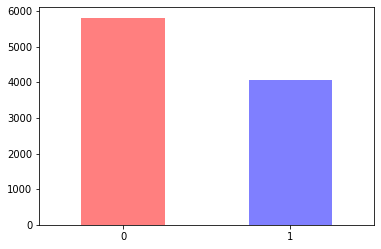

In [7]:
train_label_df.isCancerous.value_counts().plot(kind='bar', rot=0, color=['red', 'blue'], alpha=0.5)
plt.show()

There is slight imbalance in the data


In [8]:
def load_data(label_df, image_dir):
    """Load data from given label data frame and image dir

    Args
    label_df:
    image_dir:

    Returns
    """
    image_dir = Path(image_dir)
    image_filenames = label_df.ImageName.values
    targets = label_df.isCancerous.values

    images = []
    labels = []
    for i in range(len(image_filenames)):
        filename = image_filenames[i]
        label = targets[i]

        image_path = image_dir / filename
        image = np.array(Image.open(image_path))
        images.append(image)
        labels.append(label)
    images = np.stack(images, 0)
    labels = np.stack(labels, 0)
    return images, labels


image_dir = data_dir / 'patch_images'
images, labels = load_data(train_label_df, image_dir)

print('images shape: {} labels shape: {}'.format(images.shape, labels.shape))

images shape: (9896, 27, 27, 3) labels shape: (9896,)


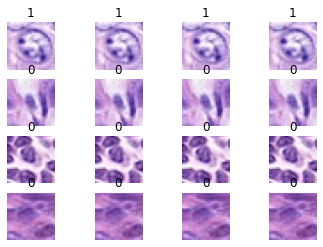

In [9]:
_, axes = plt.subplots(4, 4)
indices = np.random.choice(len(images), 16)
image_samples = images[indices]
label_samples = labels[indices]
for i in range(4):
    for j in range(4):
        axes[i, j].imshow(image_samples[i])
        axes[i, j].axis('off')
        axes[i, j].set_title(str(label_samples[i]))
plt.show()

## Image preprocessing and normalization



In [10]:
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.1, random_state=12)

train_images = train_images.astype('float32') / 255.
val_images = val_images.astype('float32') / 255.

print('train_images shape: {} train_labels shape: {}'.format(train_images.shape, train_labels.shape))
print('val_images shape: {} val_labels shape: {}'.format(val_images.shape, val_labels.shape))

train_images shape: (8906, 27, 27, 3) train_labels shape: (8906,)
val_images shape: (990, 27, 27, 3) val_labels shape: (990,)


## Baseline
We will build a baseline model first

In [11]:
model = Sequential([
    layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(27, 27, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()
model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(
    train_images, train_labels,
    batch_size=32,
    epochs=20,
    validation_data=(val_images, val_labels),
    verbose=1
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               295040    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

Learning curve

In [12]:
def plot(hist):
    plt.figure(figsize=(20, 8))
    plt.subplot(121)
    plt.plot(hist.epoch, hist.history['accuracy'], label='training')
    plt.plot(hist.epoch, hist.history['val_accuracy'], label='validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.subplot(122)
    plt.plot(hist.epoch, hist.history['loss'], label='training')
    plt.plot(hist.epoch, hist.history['val_loss'], label='validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

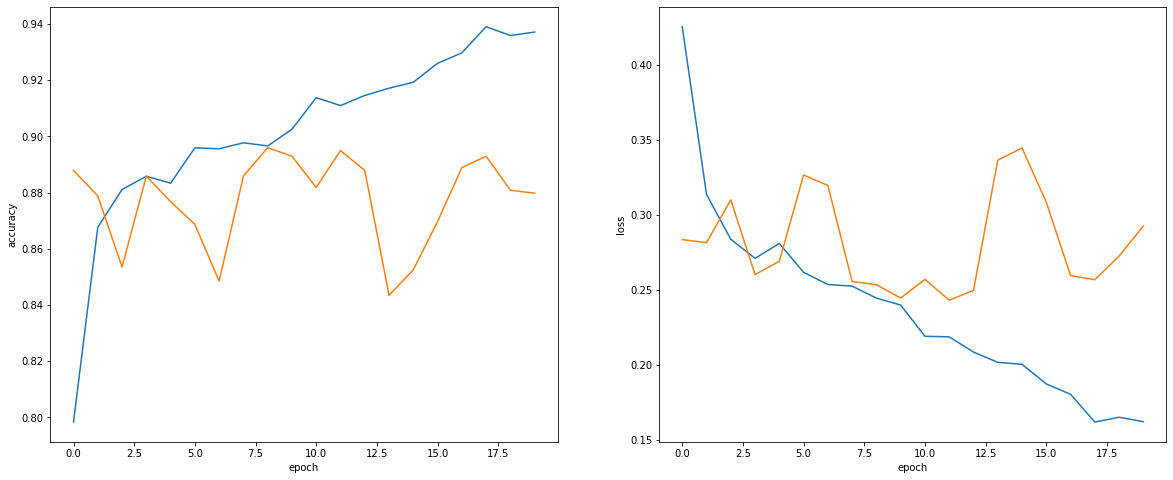

In [13]:
plot(hist)

So we could get around $~90\%$ accuracy with only baseline model. This is a good start. In next step, we will try to improve it by using deeper network.

## Deep Neural Networks
We will go for a ResNet.

In [14]:
def res_block(x, filters, kernel_size=3, stride=1):
    """
    """
    shortcut = x
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if stride > 1:
        shortcut = Conv2D(filters, 1, strides=stride)(shortcut)
    x = Conv2D(filters, 3, strides=stride, padding='same')(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, strides=1, padding='same')(x)
    return x + shortcut


def ResNet18(input_shape, num_classes=1, include_top=True):
    inputs = Input(input_shape)
    x = ZeroPadding2D(((3, 2), (3, 2)))(inputs)
    x = Conv2D(16, 3, 1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = res_block(x, 16, 3, 1)
    x = res_block(x, 16, 3, 1)

    x = res_block(x, 64, 3, 2)
    x = res_block(x, 64, 3, 1)

    x = res_block(x, 128, 3, 2)
    x = res_block(x, 128, 3, 1)

    x = res_block(x, 256, 3, 2)
    x = res_block(x, 256, 3, 1)

    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    if include_top:
        if num_classes > 1:
            x = Dense(num_classes, activation='softmax')(x)
        else:
            x = Dense(num_classes, activation='sigmoid')(x)

    return tf.keras.Model(inputs, x)

In [15]:

input_shape = (27, 27, 3)
model = ResNet18(input_shape)
model.summary()

# Learning rate scheduler
learning_rate = 1e-3
lr_drop = 20
epochs = 200

def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False  # randomly flip images
)

datagen.fit(train_images)
model.compile(optimizer=optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(
    datagen.flow(train_images, train_labels),
    batch_size=128,
    epochs=epochs,
    validation_data=(val_images, val_labels),
    verbose=1,
    callbacks=[reduce_lr]
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 27, 27, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 16)   448         zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d_2[0][0]                   
______________________________________________________________________________________________

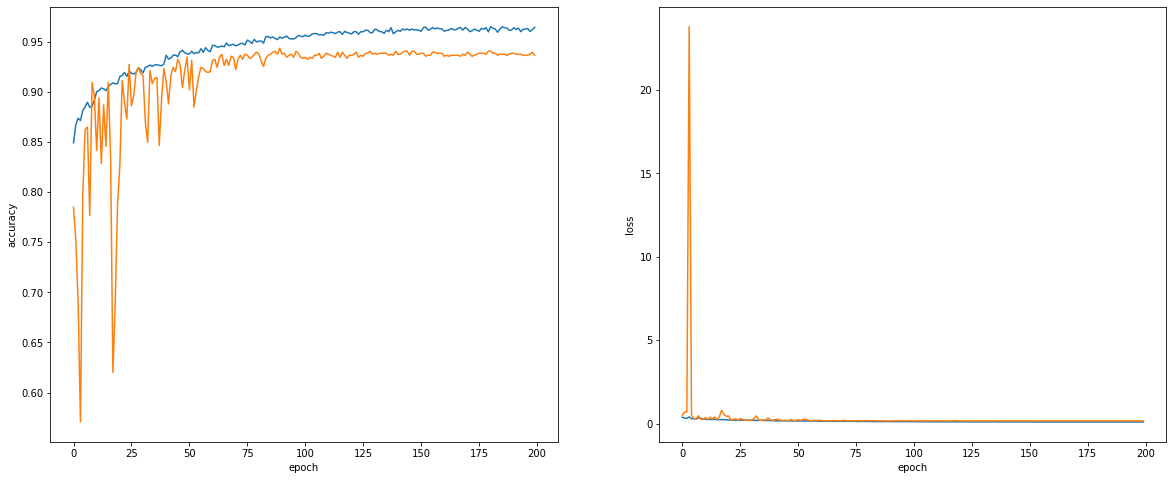

In [16]:
plot(hist)

# CellType Classification
In this section, we will classify cells according to their cellTypes: 

In [18]:
data_dir = Path('/content/drive/MyDrive/Colab Notebooks')
train_label_path = data_dir / 'data_labels_mainData.csv'
# test_label_path = data_dir / 'data_labels_extraData.csv'

train_label_df = pd.read_csv(train_label_path)
# test_label_df = pd.read_csv(test_label_path)

train_label_df.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [19]:
def load_categorical_data(label_df, image_dir):
    """Load data from given label data frame and image dir

    Args
    label_df:
    image_dir:

    Returns
    """
    image_dir = Path(image_dir)
    image_filenames = label_df.ImageName.values
    raw_targets = label_df.cellTypeName.values
    classes = np.unique(raw_targets)
    class_map = {class_name: class_id for class_id, class_name in enumerate(classes)}
    id2class = {class_id: class_name for class_name, class_id in class_map.items()}

    images = []
    labels = []
    for i in range(len(image_filenames)):
        filename = image_filenames[i]
        label = raw_targets[i]

        image_path = image_dir / filename
        image = np.array(Image.open(image_path))
        images.append(image)
        labels.append(class_map[label])
    images = np.stack(images, 0)
    labels = np.stack(labels, 0)
    return images, labels, id2class, classes


image_dir = data_dir / 'patch_images'
images, labels, id2class, classes = load_categorical_data(train_label_df, image_dir)
# test_images, test_labels, _ = load_categorical_data(test_label_df, image_dir)

print('images shape: {} labels shape: {}'.format(images.shape, labels.shape))
print('Classes:', classes)
# print('test_images shape: {} test_labels shape: {}'.format(test_images.shape, test_labels.shape))

images shape: (9896, 27, 27, 3) labels shape: (9896,)
Classes: ['epithelial' 'fibroblast' 'inflammatory' 'others']


Let's take a look at categorical data

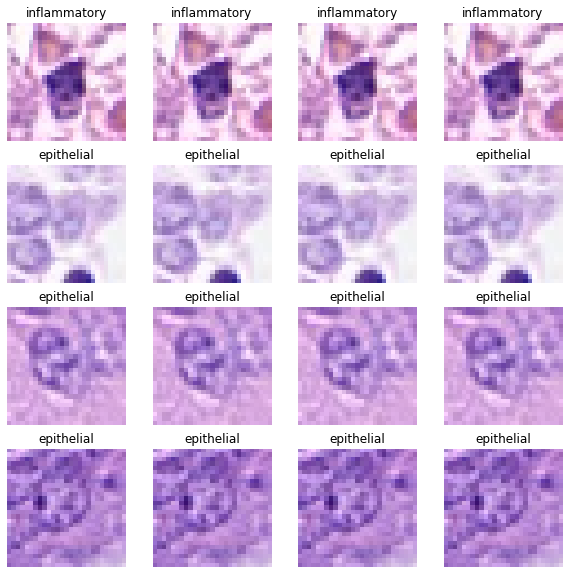

In [20]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
indices = np.random.choice(len(images), 16)
image_samples = images[indices]
label_samples = labels[indices]
for i in range(4):
    for j in range(4):
        axes[i, j].imshow(image_samples[i])
        axes[i, j].axis('off')
        axes[i, j].set_title(str(id2class[label_samples[i]]))
plt.show()

## Image preprocessing and normalization



In [21]:
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.1, random_state=12)

train_images = train_images.astype('float32') / 255.
val_images = val_images.astype('float32') / 255.
# test_images = test_images.astype('float32') / 255.

print('train_images shape: {} train_labels shape: {}'.format(train_images.shape, train_labels.shape))
print('val_images shape: {} val_labels shape: {}'.format(val_images.shape, val_labels.shape))
# print('test_images shape: {} test_labels shape: {}'.format(test_images.shape, test_labels.shape))

train_images shape: (8906, 27, 27, 3) train_labels shape: (8906,)
val_images shape: (990, 27, 27, 3) val_labels shape: (990,)


## Baseline
We will start with a baseline model for cellType classification.

In [22]:
model = Sequential([
    layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(27, 27, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])

model.summary()
model.compile(optimizer=optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(
    train_images, train_labels,
    batch_size=32,
    epochs=20,
    validation_data=(val_images, val_labels),
    verbose=1
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 27, 27, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               295040    
_________________________________________________________________
dense_5 (Dense)              (None, 4)                

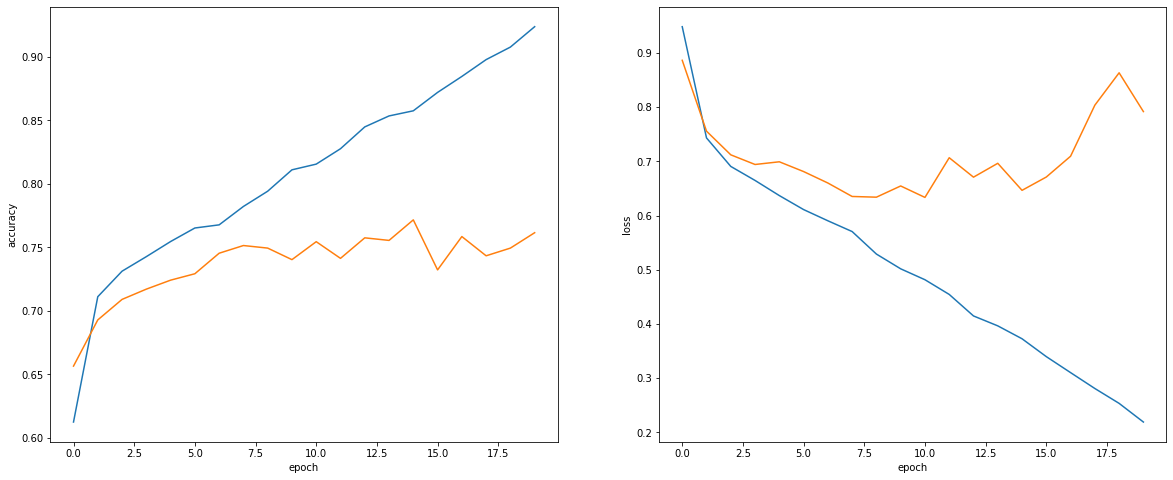

In [ ]:
plot(hist)

## Improving The CellType classification 

We will ultilize the large extra dataset to train a network. The pretrained network will be used in transfer learning to improve the cell-type classification model.

### Train on the extra dataset

In [23]:
data_dir = Path('/content/drive/MyDrive/Colab Notebooks')
train_extra_label_path = data_dir / 'data_labels_extraData.csv'

train_extra_label_df = pd.read_csv(train_extra_label_path)

image_dir = data_dir / 'patch_images'
extra_images, extra_labels = load_data(train_extra_label_df, image_dir)

# Normalize
extra_labels = extra_labels.astype('int32')
print('images shape: {} labels shape: {}'.format(extra_images.shape, extra_labels.shape))

images shape: (10384, 27, 27, 3) labels shape: (10384,)


In [25]:
extra_train_images, extra_val_images, extra_train_labels, extra_val_labels = train_test_split(extra_images, extra_labels, test_size=0.1, random_state=12)

extra_train_images = extra_train_images.astype('float32') / 255.
extra_val_images = extra_val_images.astype('float32') / 255.

print('train_images shape: {} train_labels shape: {}'.format(extra_train_images.shape, extra_train_labels.shape))
print('val_images shape: {} val_labels shape: {}'.format(extra_val_images.shape, extra_val_labels.shape))

train_images shape: (9345, 27, 27, 3) train_labels shape: (9345,)
val_images shape: (1039, 27, 27, 3) val_labels shape: (1039,)


In [26]:
input_shape = (27, 27, 3)
model = ResNet18(input_shape, num_classes=1)
model.summary()

# Learning rate scheduler
learning_rate = 1e-3
lr_drop = 20
epochs = 200

def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False  # randomly flip images
)
checkpoint_dir = './pretrained_models'
if os.path.isdir(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)
os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, 'resnet_celltype_model_{epoch:03d}_{val_accuracy:.4f}.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_prefix,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_weights_only=True)

datagen.fit(extra_train_images)
model.compile(optimizer=optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(
    datagen.flow(extra_train_images, extra_train_labels),
    batch_size=128,
    epochs=epochs,
    validation_data=(extra_val_images, extra_val_labels),
    verbose=1,
    callbacks=[reduce_lr, checkpoint]
)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 27, 27, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 32, 32, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 32, 32, 16)   448         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 32, 32, 16)   64          conv2d_24[0][0]                  
____________________________________________________________________________________________

### Transfer Learning

In [27]:
def load_best_weights(model, weights_dir):
    """
    """
    bin_model = ResNet18(model.input.shape[1:], 1)
    paths = glob.glob(os.path.join(weights_dir, '*.h5'))
    best_weights = sorted(paths, key=lambda x: float(x.split('_')[-1][:-3]))[::-1][0]
    print('Loading weights from {}'.format(best_weights))
    bin_model.load_weights(best_weights)
    
    for i in range(len(model.layers)):
        model.layers[i].set_weights(bin_model.layers[i].get_weights())

    return model


pretrained_dir = './pretrained_models'
input_shape = (27, 27, 3)
base_model = ResNet18(input_shape, include_top=False)
base_model = load_best_weights(base_model, pretrained_dir)
for layer in base_model.layers[:-3]:
    layer.trainable = False

model = tf.keras.Sequential([
    base_model,
    Dense(4, activation='softmax'),
])
model.summary()

# Learning rate scheduler
learning_rate = 1e-3
lr_drop = 20
epochs = 200

def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False  # randomly flip images
)

datagen.fit(train_images)
model.compile(optimizer=optimizers.Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(
    datagen.flow(train_images, train_labels),
    batch_size=128,
    epochs=epochs,
    validation_data=(val_images, val_labels),
    verbose=1,
    callbacks=[reduce_lr]
)

Loading weights from ./pretrained_models/resnet_celltype_model_199_0.9519.h5
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 512)               2892352   
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 2052      
Total params: 2,894,404
Trainable params: 133,636
Non-trainable params: 2,760,768
_________________________________________________________________
Epoch 1/200
279/279 [==============================] - 6s 17ms/step - loss: 3.7198 - accuracy: 0.5325 - val_loss: 0.9389 - val_accuracy: 0.6313
Epoch 2/200
279/279 [==============================] - 4s 16ms/step - loss: 1.3243 - accuracy: 0.6245 - val_loss: 1.1500 - val_accuracy: 0.6131
Epoch 3/200
279/279 [==============================] - 5s 16ms/step - loss: 1.2157 - accuracy: 0.6461 - val_loss: 1.1590 - val_accuracy

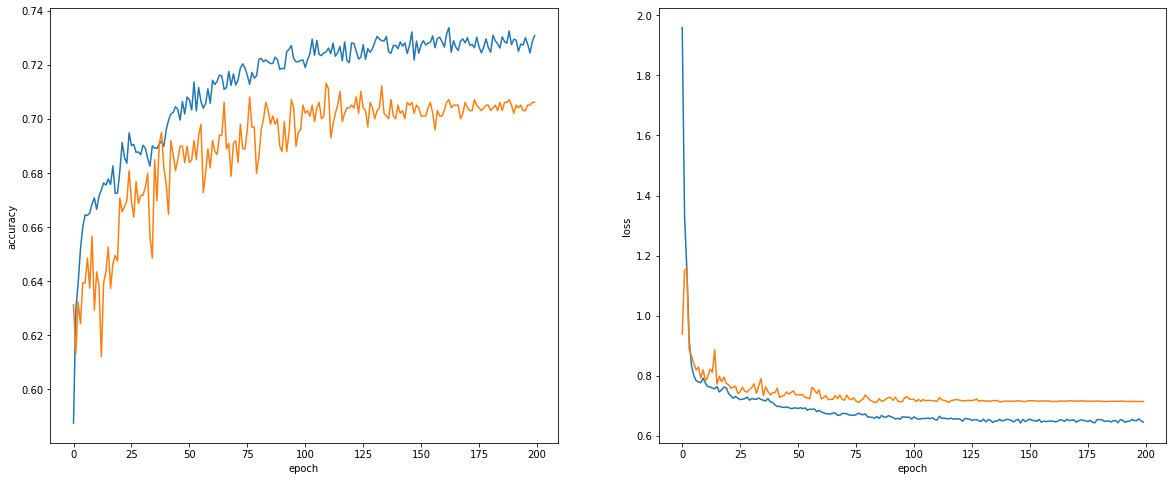

In [28]:
plot(hist)